<a href="https://colab.research.google.com/github/Thabet-Chaaouri/Sentence_similarity/blob/main/Clustering_sb_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [ ]:
!pip install plotly datasets bertopic
!pip install -U sentence-transformers
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from datasets import load_dataset
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from spacy.lang.fr.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from huggingface_hub import notebook_login

notebook_login()

#Load data

In [ ]:
dataset = load_dataset("Thabet/data_clustering_sb")

filtered_dataset = dataset.filter(lambda example: (example["week"] == 20) & (example["year"] == 2023) & (not example["Origin_sb"].startswith("RN")))

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
docs = filtered_dataset["train"]["Text_sb"]

#Load model

In [ ]:
model_ckpt = "Thabet/all-mpnet-base-v2_for_sb_clustering"

embedding_model = SentenceTransformer(model_ckpt)

In [ ]:
embeddings = embedding_model.encode(docs, )

#Bertopic

In [ ]:
french_stopwords = list(STOP_WORDS)
vectorizer_model = CountVectorizer(stop_words=french_stopwords, ngram_range=(1, 2),)

umap_model = UMAP(n_neighbors=15, n_components=20, metric='cosine', low_memory=False)

In [ ]:
# Train our topic model using our pre-trained sentence-transformers embeddings
topic_model = BERTopic(vectorizer_model=vectorizer_model, umap_model=umap_model)
topics, probs = topic_model.fit_transform(docs, embeddings)

#Evaluation

## Silhouette score

In [ ]:
umap_embeddings = umap_model.fit_transform(embeddings)

In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples

# Calculate the silhouette score
silhouette_avg = silhouette_score(umap_embeddings, topics)

# Print the silhouette score
print("The average silhouette score is:", silhouette_avg)


The average silhouette score is: 0.044351917


In [ ]:
import numpy as np

# Create a boolean mask based on the condition
mask = np.array(topics) == -1

filtered_topics = [topic for topic in topics if topic != -1]

# Filter the embeddings array based on the mask
filtered_embeddings = umap_embeddings[~mask]

In [ ]:
# Calculate the silhouette score
silhouette_avg = silhouette_score(filtered_embeddings, filtered_topics)

# Print the silhouette score
print("The average silhouette score is:", silhouette_avg)

The average silhouette score is: 0.544623


## Silhouette plots

In [ ]:
silhouette_values = silhouette_samples(filtered_embeddings, filtered_topics)

<ipython-input-67-aa191a3791db>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = plt.cm.get_cmap('Spectral')(float(i) / best_cluster_number)


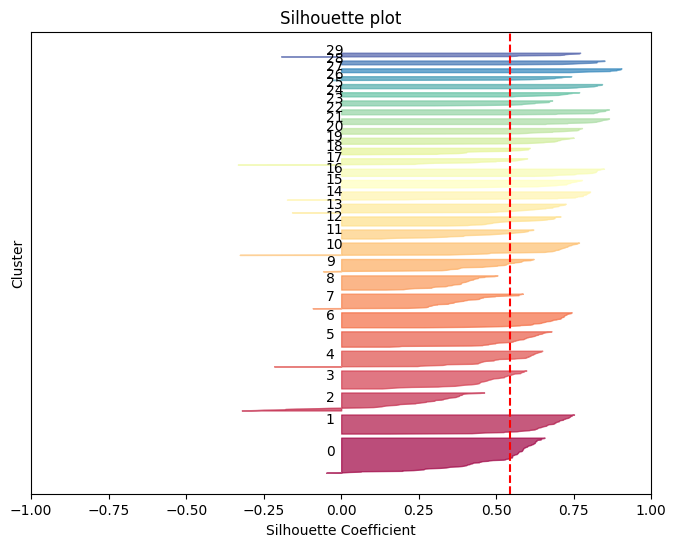

In [ ]:
# Create a subplot with 1 row and 1 column
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Set the y-axis limits for the silhouette plot
y_lower = 10

best_cluster_number = len(set(filtered_topics))
# Loop over the clusters to plot individual silhouettes
for i in range(best_cluster_number):
    # Aggregate the silhouette scores for samples belonging to the current cluster
    ith_cluster_silhouette_values = silhouette_values[np.array(filtered_topics)  == i]
    ith_cluster_silhouette_values.sort()

    # Calculate the y-axis limits for the current cluster
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    # Fill the silhouette plot
    color = plt.cm.get_cmap('Spectral')(float(i) / best_cluster_number)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Calculate the new y_lower for the next plot
    y_lower = y_upper + 10

# Set labels and ticks for the plot
ax.set_xlabel("Silhouette Coefficient")
ax.set_ylabel("Cluster")
ax.set_yticks([])
ax.set_xlim([-1, 1])

# Draw a vertical line for the average silhouette score
ax.axvline(x=silhouette_avg, color="red", linestyle="--")

# Add a title to the plot
ax.set_title("Silhouette plot")

plt.show()

##Evaluation with an LLM